# Electricity Usage Analysis

## Problem Description

    
In this challenge, you are asked to explore a dataset describing a household's environmental conditions and electricity usage. The dataset is a time series with variables representing the internal temperature and humidity monitored by sensors, the electricity usage sourced from the energy meter, and external weather conditions provided by a local weather station. All variables have been summarised into 10-minute intervals over a four-month period (2016 January to 2016 May). We are interested in predicting the electricity usage of the household (the variable named 'Appliances' in the dataset) given the internal and external environmental conditions. 


There are three tasks (in detailed task description can be in the later sections) you need to complete:  <br>
1. Modelling 
2. Model Performance 
3. Prediction


## Data Description

Column | Description
:---|:---
`date` |Timestamp
`Appliances` |Energy use in Wh
`lights` |Energy use of light fixtures in the house in Wh 
`T1`	|Temperature in kitchen area, in Celsius
`RH_1`	|Humidity in kitchen area, in % 
`T2`	|Temperature in living room area, in Celsius 
`RH_2`	|Humidity in living room area, in % 
`T3`	|Temperature in laundry room area 
`RH_3`	|Humidity in laundry room area, in % 
`T4`	|Temperature in office room, in Celsius 
`RH_4`	|Humidity in office room, in % 
`T5`	|Temperature in bathroom, in Celsius 
`RH_5`	|Humidity in bathroom, in % 
`T6`	|Temperature outside the building (north side), in Celsius 
`RH_6`	|Humidity outside the building (north side), in %
`T7`	|Temperature in ironing room , in Celsius 
`RH_7` 	|Humidity in ironing room, in % 
`T8` 	|Temperature in teenager room 2, in Celsius 
`RH_8` 	|Humidity in teenager room 2, in % 
`T9` 	|Temperature in parents room, in Celsius 
`RH_9` 	|Humidity in parents room, in % 
`T_out` 	|Temperature outside (from weather station), in Celsius
`Press_mm_hg`   |Pressure (from weather station), in mm Hg
`RH_out`    |Humidity outside (from weather station), in %
`Windspeed` |from weather station, in m/s 
`Visibility`    |from weather station, in km 
`Tdewpoint` |from weather station Â°C
`v1`	|unknown
`v2`	|unknown


    If you'd like to install packages that aren't installed by default. For example in Python, uncomment the last two lines of this cell and replace <package list> with a list of your packages. This will ensure your notebook has all the dependencies and works everywhere

In [1]:
for name in dir():
    if not name.startswith("_"):
        del globals()[name]

In [2]:
import sys
!{sys.executable} -m pip install hvplot

In [199]:
# Libraries
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import hvplot.pandas

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [86]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [44]:
df2 = pd.read_csv('df2.csv', header='infer')
df2.set_index('date', inplace=True)
print(df2.shape)
df2.head()

(16459, 27)


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433
2016-01-11 17:10:00,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,NaN,48.863333,NaN,45.56,6.483333,733.6,92.0,6.666667,NaN,5.2,18.606195
2016-01-11 17:20:00,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,NaN,92.0,6.333333,55.333333,5.1,28.642668
2016-01-11 17:30:00,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,NaN,6.000000,51.500000,5.0,45.410390
2016-01-11 17:40:00,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,NaN,18.1,48.590000,17.000000,45.40,6.133333,733.9,NaN,5.666667,47.666667,4.9,10.084097


In [45]:
df2_missing = pd.concat([df2.nunique(), df2.isnull().any(), df2.isnull().mean()], axis=1)
df2_missing.columns = ['nunique', 'isnull_any', 'isnull_proportion']
df2_missing

,nunique,isnull_any,isnull_proportion
Appliances,91,False,0.000000
lights,8,True,0.006015
T1,455,True,0.130324
RH_1,1990,True,0.130688
T2,1000,True,0.138465
RH_2,2193,True,0.117686
T3,906,True,0.132815
RH_3,1937,True,0.120906
T4,1058,True,0.087612
RH_4,2353,True,0.125828


In [46]:
df3 = df2.fillna(df2.median())

if 0:
    df3_missing = pd.concat([df3.nunique(), df3.isnull().any(), df3.isnull().mean()], axis=1)
    df3_missing.columns = ['nunique', 'isnull_any', 'isnull_proportion']
    df3_missing

In [222]:
df3['lights'].value_counts()

0.0     12559
10.0     1948
20.0     1389
30.0      480
40.0       74
50.0        7
60.0        1
70.0        1
Name: lights, dtype: int64

In [47]:
print(df3.shape)
df3.head()

(16459, 27)


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.20,48.900000,17.033333,45.53,6.600000,733.5,92.000000,7.000000,63.000000,5.3,13.275433
2016-01-11 17:10:00,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,21.79,48.863333,18.890000,45.56,6.483333,733.6,92.000000,6.666667,40.000000,5.2,18.606195
2016-01-11 17:20:00,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.20,48.730000,17.000000,45.50,6.366667,755.0,92.000000,6.333333,55.333333,5.1,28.642668
2016-01-11 17:30:00,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.10,48.590000,17.000000,45.40,6.250000,733.8,84.333333,6.000000,51.500000,5.0,45.410390
2016-01-11 17:40:00,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,34.927778,18.10,48.590000,17.000000,45.40,6.133333,733.9,84.333333,5.666667,47.666667,4.9,10.084097


In [121]:
df3.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1
count,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.000000,16459.00000,16459.000000,16459.000000
mean,96.233064,3.955283,21.411526,40.169764,20.036250,40.440233,21.935220,39.375334,20.468408,39.095497,19.286999,51.174386,7.166662,59.619036,19.787542,35.457365,21.692460,43.134914,19.029985,41.566813,6.848526,754.794260,80.719657,4.120142,38.61759,3.335968,24.934725
std,102.028297,8.060528,1.389577,3.513932,1.875805,3.643092,1.668433,3.038812,1.807956,3.971781,1.548120,8.694324,5.296161,28.978911,1.760854,4.457492,1.717435,4.855274,1.674996,3.856741,4.901699,6.937394,14.110826,2.358126,10.59493,3.680742,14.517159
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.596667,17.200000,30.663333,15.100000,27.660000,15.330000,29.815000,-6.030000,1.000000,15.390000,23.200000,16.362222,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.00000,-6.600000,0.005322
25%,50.000000,0.000000,20.790000,37.900000,18.890000,38.400000,20.823333,37.290000,19.390000,36.290000,18.200000,46.090000,3.933333,40.725000,18.700000,32.500000,20.790000,39.568036,18.000000,38.976500,3.663889,751.100000,73.000000,2.333333,32.50000,1.166667,12.425313
50%,60.000000,0.000000,21.390000,39.626667,19.760000,40.590000,21.890000,38.730000,20.390000,38.500000,19.260000,49.400000,6.656667,62.261667,19.600000,34.927778,21.790000,42.600000,18.890000,41.000000,6.400000,755.000000,84.333333,3.833333,40.00000,3.200000,24.774977
75%,100.000000,0.000000,22.100000,42.433333,20.790000,42.826667,22.790000,41.290000,21.390000,41.465000,20.200000,53.334000,9.726667,84.945000,20.926667,37.905409,22.730000,46.060000,20.251429,43.760000,9.600000,759.266667,91.166667,5.333333,40.00000,5.486111,37.583769
max,1080.000000,70.000000,25.700000,63.360000,29.856667,56.026667,27.600000,50.163333,26.200000,51.090000,25.745000,96.321667,28.236000,99.900000,25.390000,51.400000,27.230000,58.780000,24.200000,53.326667,26.100000,772.300000,100.000000,14.000000,66.00000,15.500000,49.996530


Appliances -0.21655783519823987


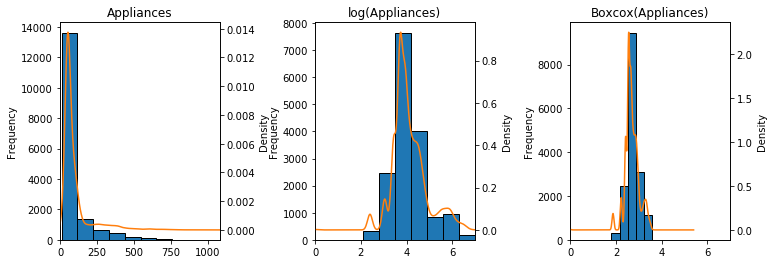

lights -1.3785448161467846


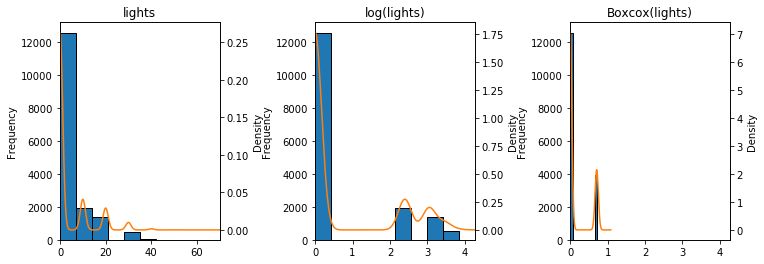

T1 0.9828093066561051


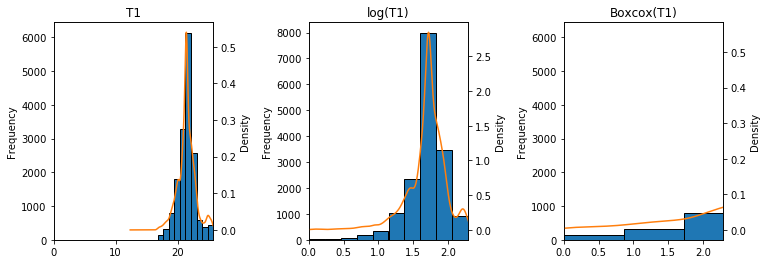

RH_1 0.5739294346798417


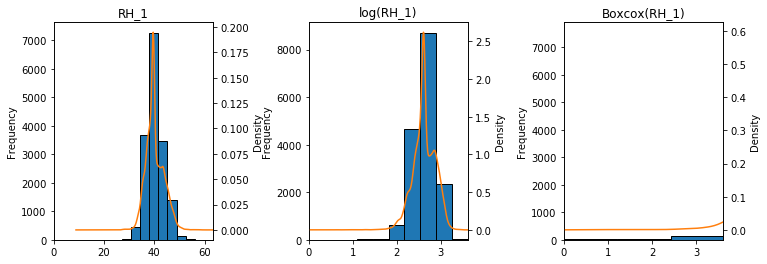

T2 0.26899198096290816


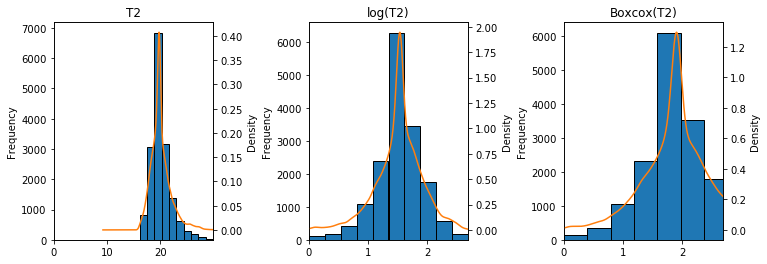

RH_2 1.7614379137109746


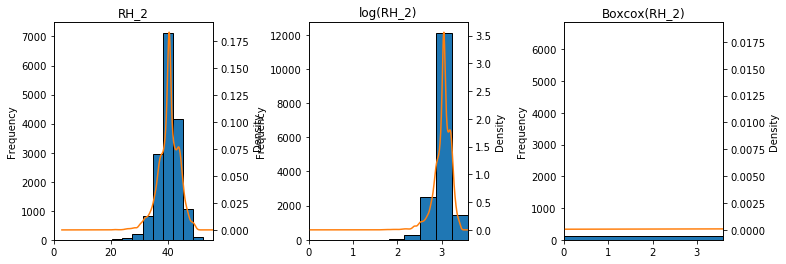

T3 0.6930087243742546


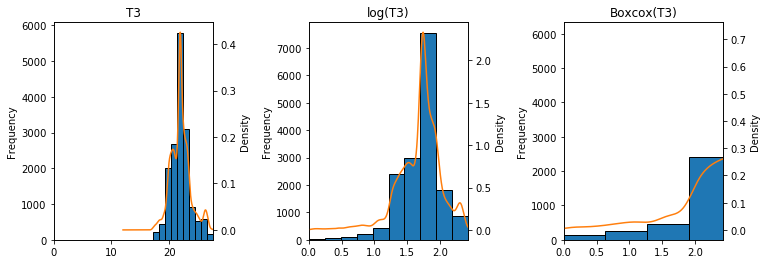

RH_3 0.20541411271708537


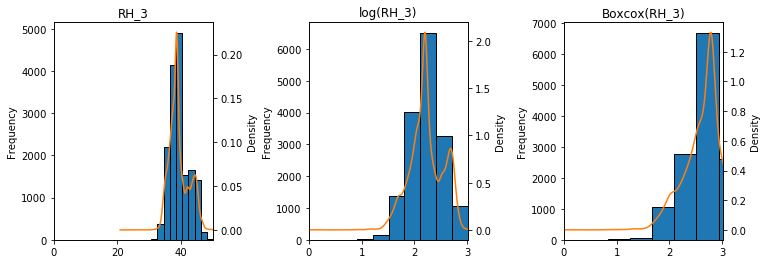

T4 0.8724643113407835


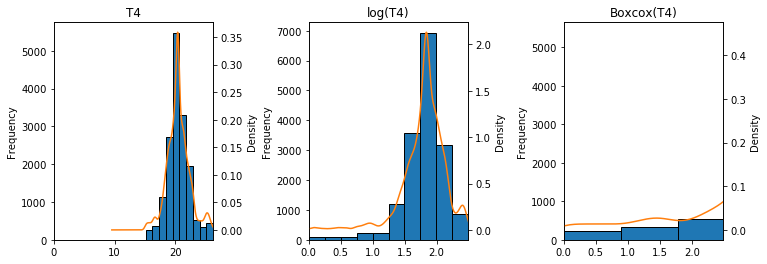

RH_4 0.3177204928258589


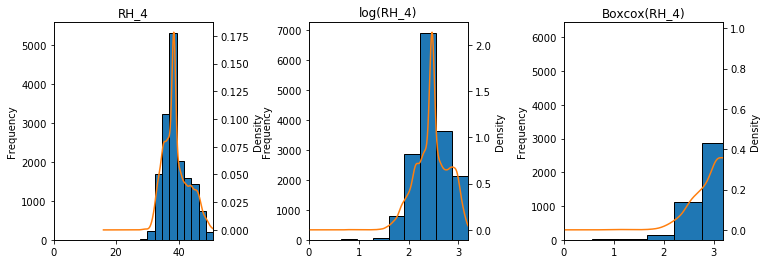

T5 0.647339470410403


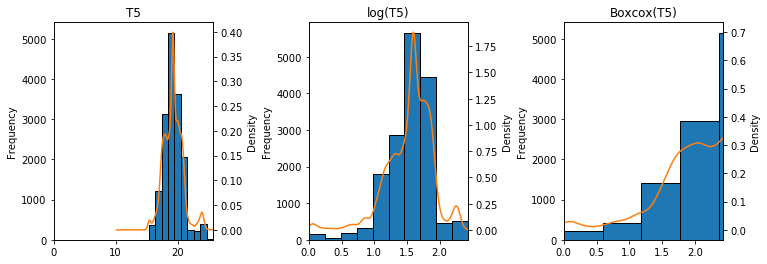

RH_5 -0.09531605699765613


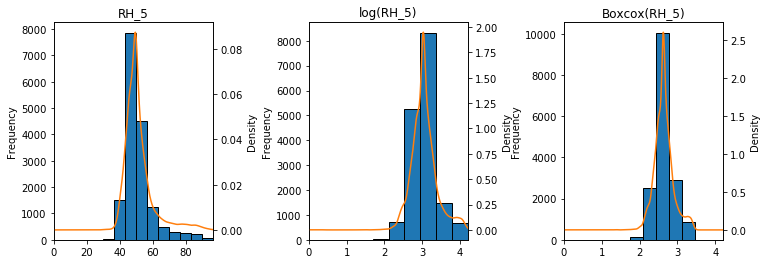

T6 0.6433966778258241


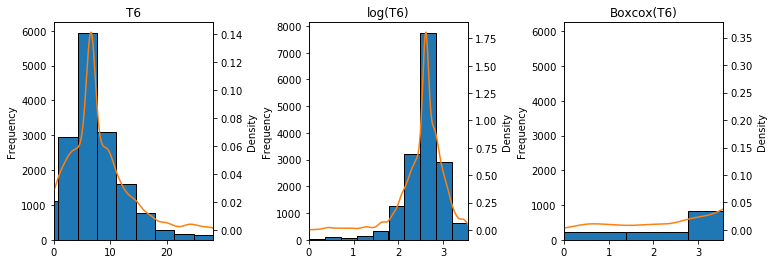

RH_6 0.9824482141280644


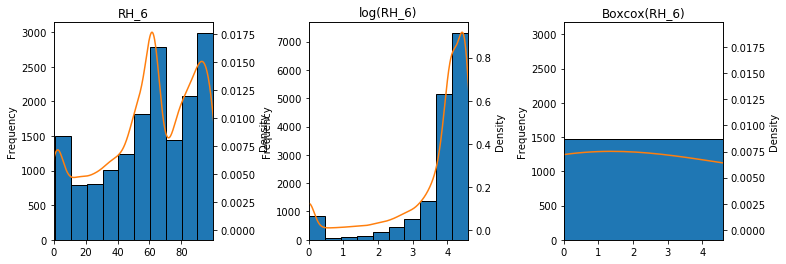

T7 0.7075052873332203


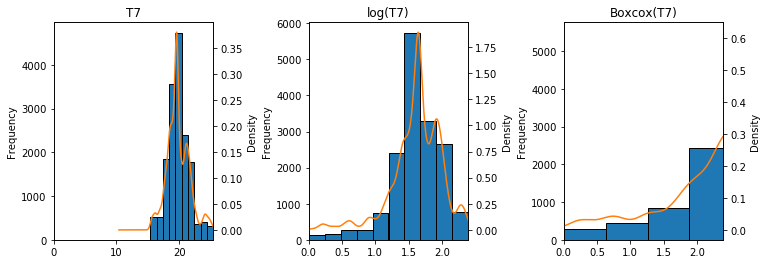

RH_7 0.604576443517989


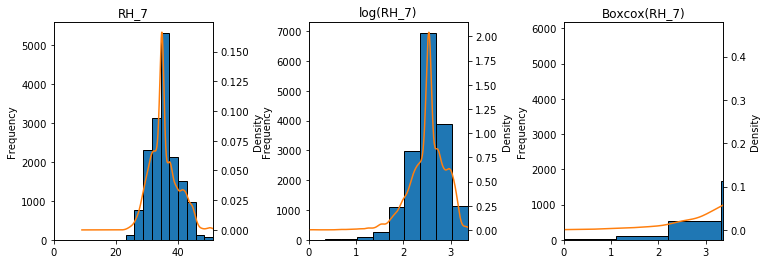

T8 1.2451127422155057


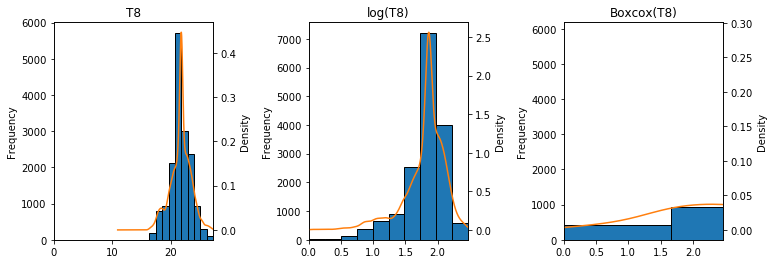

RH_8 0.5025448632123112


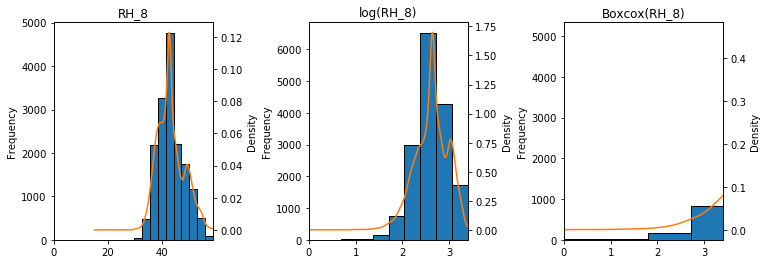

T9 0.6265203112772123


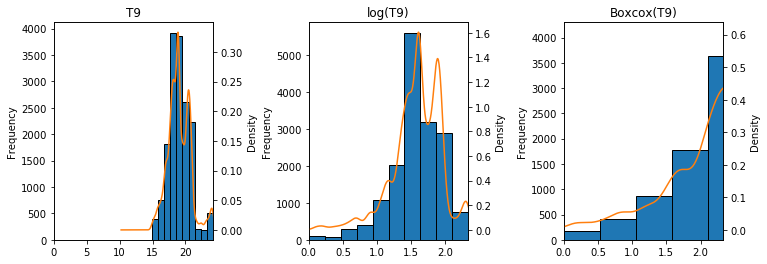

RH_9 0.5207180446505033


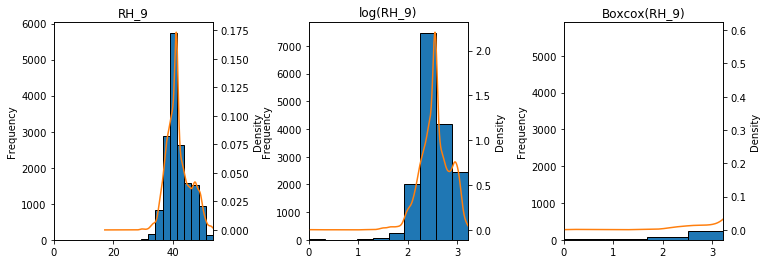

T_out 0.6317321783799436


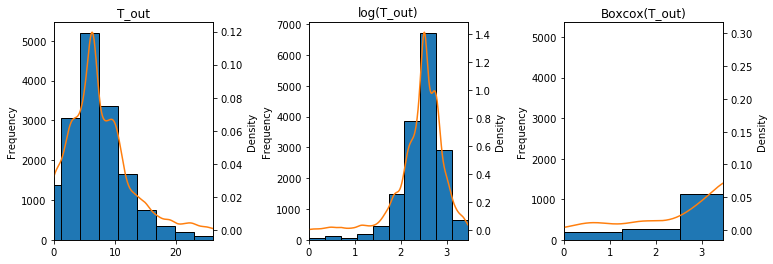

Press_mm_hg 1.3840397173005374


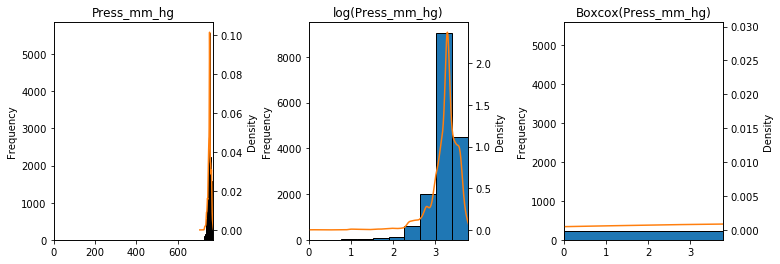

RH_out 2.3924716158795274


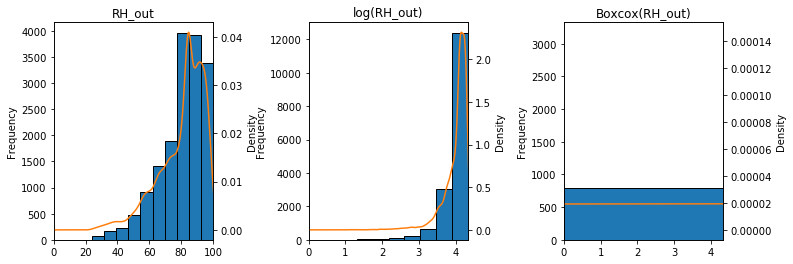

Windspeed 0.11773695335303155


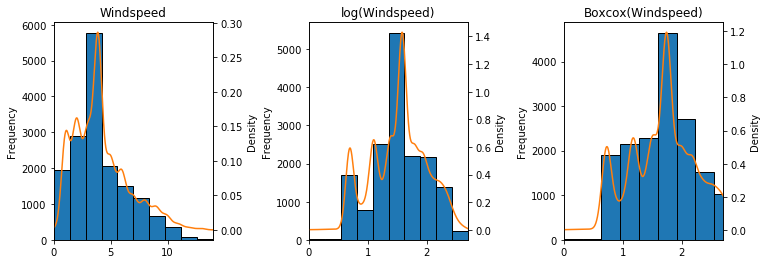

Visibility 0.7355761145278843


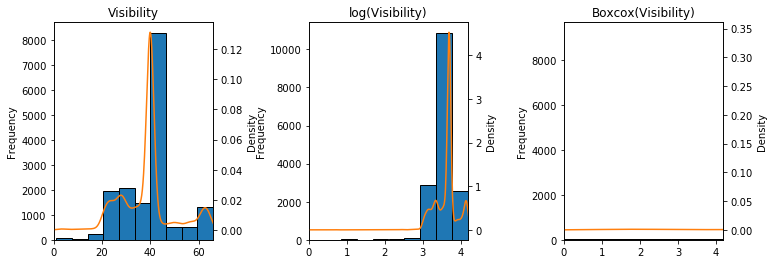

Tdewpoint 0.9139053804159235


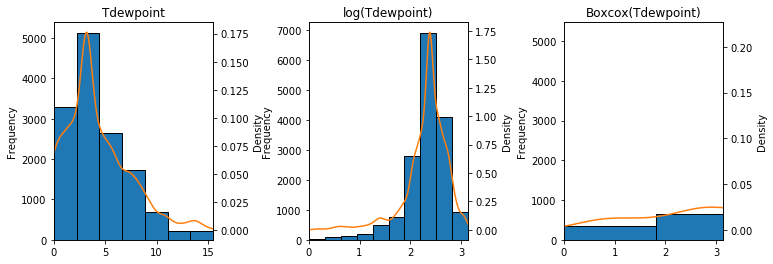

v1 0.7164238759438825


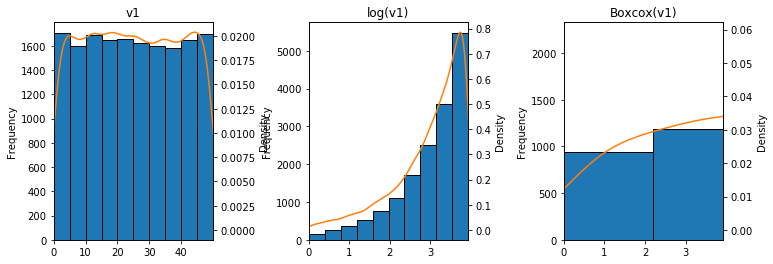

In [196]:
for col in df3.columns:
    fig = plt.figure(figsize=(12, 4))
    plt.subplots_adjust(wspace=0.6)
    
    plt.subplot(1, 3, 1)
    v = df3[col]
    ax = v.plot(kind='hist', edgecolor='black')
    ax2 = v.plot(kind='kde', ax=ax, secondary_y=True, xlim=[0, max(v)])
    ax.set_ylabel('Frequency')
    ax2.set_ylabel('Density')
    ax.set_title(col)

    plt.subplot(1, 3, 2)
    v = df3[col] - df3[col].min() + 1
    ax = np.log(v).plot(kind='hist', edgecolor='black')
    ax2 = np.log(v).plot(kind='kde', ax=ax, secondary_y=True, xlim=[0, max(np.log(v))])
    ax.set_ylabel('Frequency')
    ax2.set_ylabel('Density')
    ax.set_title('log(' + col + ')')
    
    plt.subplot(1, 3, 3)
    l, opt_lambda = boxcox(v)
    print(col, opt_lambda)
    vt = pd.Series(boxcox(v, lmbda=opt_lambda))
    ax = vt.plot(kind='hist', edgecolor='black')
    ax2 = vt.plot(kind='kde', ax=ax, secondary_y=True, xlim=[0, max(np.log(v))])
    ax.set_ylabel('Frequency')
    ax2.set_ylabel('Density')
    ax.set_title('Boxcox(' + col + ')')
    
    plt.show()

In [203]:
# some testing ...
if 0:
    x = df3['Appliances'] - df3['Appliances'].min() + 1
    print(x[0:10].tolist())

    xbox, opt_lambda = boxcox(x)
    print(xbox[0:10].tolist())
    print(opt_lambda)

    xinvbox = inv_boxcox(xbox, opt_lambda)
    print(xinvbox[0:10].tolist())

[51.0, 51.0, 41.0, 41.0, 51.0, 41.0, 51.0, 51.0, 51.0, 61.0]
[2.646922942509263, 2.646922942509263, 2.5515385251450624, 2.5515385251450624, 2.646922942509263, 2.5515385251450624, 2.646922942509263, 2.646922942509263, 2.646922942509263, 2.7218760785681684]
-0.21655783519823987
[51.00000000000002, 51.00000000000002, 41.00000000000001, 41.00000000000001, 51.00000000000002, 41.00000000000001, 51.00000000000002, 51.00000000000002, 51.00000000000002, 60.99999999999995]


In [204]:
excluded_cols = ['Appliances']
features = [col for col in df3.columns if col not in excluded_cols]
X = df3[features]
y = df3['Appliances']

In [175]:
#scoring = make_scorer(r2_score)
scoring = make_scorer(root_mean_squared_error, greater_is_better=False)

In [176]:
#-------------------------------------------------------------------------------
# Execute the cross-validation for all parameter combinations and plots the
# evaluation metrics. At each iteration of the cross validation process, the 
# model is evaluated using all the below metrics but the optimal model is 
# determined using the AUC score (as this minimizes both false positives &
# false negatives).
#-------------------------------------------------------------------------------
def build_optimal_model(model_type, model, model_parameter_grid, X, y, scoring):
    grid_object = GridSearchCV(model, param_grid=model_parameter_grid, cv=5, scoring=scoring, refit=True, return_train_score=True, n_jobs=-1)
    print('Performing grid search to determine the optimal parameters ...')
    grid_object.fit(X, y)
    grid_search_output = pd.DataFrame(grid_object.cv_results_)

    optimal_model = grid_object.best_estimator_
    optimal_model = optimal_model.fit(X, y)

    return grid_object, grid_search_output, optimal_model

In [231]:
# Decision Tree setup
model_type = 'Decision Tree'
model = DecisionTreeRegressor(random_state=1)
MAX_HEIGHT = 20
model_parameter_grid = {
         'max_depth': range(1,(MAX_HEIGHT+1)),
         'min_samples_leaf': [25, 50, 75, 100, 125, 150, 200]
        }

In [218]:
# log transform of Appliances variable
Xt = X
yt = np.log(y)

In [219]:
%%time
grid_object, grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, Xt, yt, scoring)

Performing grid search to determine the optimal parameters ...
CPU times: user 4 s, sys: 179 ms, total: 4.17 s
Wall time: 1min 22s


In [220]:
#print(grid_object)
print(-grid_object.best_score_)
print(grid_object.best_params_)
pd.DataFrame.from_dict({'feature': features, 'importance': optimal_model.feature_importances_}).sort_values('importance', ascending=False)

0.6293092912974575
{'max_depth': 3, 'min_samples_leaf': 150}


,feature,importance
0,lights,0.526222
21,RH_out,0.270466
16,RH_8,0.107139
17,T9,0.049911
15,T8,0.046262
1,T1,0.000000
24,Tdewpoint,0.000000
23,Visibility,0.000000
22,Windspeed,0.000000
20,Press_mm_hg,0.000000


In [209]:
grid_search_output.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.040600,0.000480,0.003153,0.000143,1,25,"{'max_depth': 1, 'min_samples_leaf': 25}",-0.741635,-0.637834,-0.638048,-0.60711,-0.556969,-0.636324,0.060408,7,-0.60496,-0.630122,-0.630207,-0.638205,-0.649632,-0.630625,0.014682
1,0.040551,0.005174,0.003177,0.000093,1,50,"{'max_depth': 1, 'min_samples_leaf': 50}",-0.741635,-0.637834,-0.638048,-0.60711,-0.556969,-0.636324,0.060408,7,-0.60496,-0.630122,-0.630207,-0.638205,-0.649632,-0.630625,0.014682
2,0.041049,0.005317,0.003007,0.000157,1,75,"{'max_depth': 1, 'min_samples_leaf': 75}",-0.741635,-0.637834,-0.638048,-0.60711,-0.556969,-0.636324,0.060408,7,-0.60496,-0.630122,-0.630207,-0.638205,-0.649632,-0.630625,0.014682
3,0.040349,0.005513,0.002982,0.000180,1,100,"{'max_depth': 1, 'min_samples_leaf': 100}",-0.741635,-0.637834,-0.638048,-0.60711,-0.556969,-0.636324,0.060408,7,-0.60496,-0.630122,-0.630207,-0.638205,-0.649632,-0.630625,0.014682
4,0.040099,0.006865,0.002940,0.000206,1,125,"{'max_depth': 1, 'min_samples_leaf': 125}",-0.741635,-0.637834,-0.638048,-0.60711,-0.556969,-0.636324,0.060408,7,-0.60496,-0.630122,-0.630207,-0.638205,-0.649632,-0.630625,0.014682


In [221]:
# model evaluation
predicted = optimal_model.predict(Xt)

print(root_mean_squared_error(predicted, yt))
print(root_mean_squared_error(np.exp(predicted), np.exp(yt)))

print(r2_score(predicted, yt))
print(r2_score(np.exp(predicted), np.exp(yt)))

0.6040362362713255
99.59114559685756
-4.277098190933804
-18.911669945954653


In [236]:
# Box-Cox transformation of features
Xt = pd.DataFrame(columns=X.columns.tolist())
opt_lambda_dict = {}
for col in X.columns:
    v = X[col] - X[col].min() + 1
    vt, opt_lambda = boxcox(v)
    Xt[col] = vt
    opt_lambda_dict[col] = opt_lambda
    
yt, opt_lambda = boxcox(y)
opt_lambda_dict['Appliances'] = opt_lambda # Appliances > 0

In [232]:
%%time
grid_object, grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, Xt, yt, scoring)

Performing grid search to determine the optimal parameters ...
CPU times: user 2.22 s, sys: 144 ms, total: 2.37 s
Wall time: 1min 18s


In [233]:
#print(grid_object)
print(-grid_object.best_score_)
print(grid_object.best_params_)
pd.DataFrame.from_dict({'feature': features, 'importance': optimal_model.feature_importances_}).sort_values('importance', ascending=False)

0.06127056195251598
{'max_depth': 5, 'min_samples_leaf': 150}


,feature,importance
0,lights,0.347718
17,T9,0.221971
21,RH_out,0.128043
16,RH_8,0.064109
15,T8,0.047725
11,T6,0.045741
2,RH_1,0.032181
18,RH_9,0.028905
3,T2,0.028105
13,T7,0.024467


In [238]:
# model evaluation
predicted = optimal_model.predict(Xt)

print(root_mean_squared_error(predicted, yt))
print(root_mean_squared_error(inv_boxcox(predicted, opt_lambda_dict['Appliances']), y))

print(r2_score(predicted, yt))
print(r2_score(inv_boxcox(predicted, opt_lambda_dict['Appliances']), y))

0.05543442469583618
100.20835154069583
-2.1477154137079197
-21.378843196610717


## Modelling Task


> #### Task:
- **Exploration** <br/>
    Explore relationships or patterns in the dataset `dataset_1.csv` and create one or two informative visualisations with related discussions.
- **Modelling** <br/>
    Clean the data, preprocess if needed, choose modelling methods and implement them in you programming language of choice.  (include graphics if needed). Discuss the selected modelling option for the predictions.
  
 
> #### Deliverable:
- Well commented Jupyter notebook 
- Final report (optional)

In [4]:
#Code and comment start here

## Model Performance 

> #### Task:
- **Compute your selected model in the Modelling Task with the two metrics described as following**:<br>
    - R-Squared <br>
    $ R^2 = 1 - \frac{\text{Explained Variation}}{\text{Total Variation}}$
    - Root-Mean-Square-Error <br>    
    $ RMSE = \sqrt{\frac{\sum (\text{Predicted}_i - \text{Actual}_i)^2}{a}}$

> #### Deliverables:
- Report the $R^2$ and $RMSE$ values in the `Question 2 Model Performance` .


In [5]:
# Code and comment starts here

## Prediction Task

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the second dataset (`dataset_2.csv`), you must predict the value of the `Appliances` variable. You should submit a CSV file with a header row and one row per test entry.

> #### Deliverable:
- The file (`submissions.csv`) should have exactly 2 columns:
   - **date**
   - **Appliances** 

> #### Submission option:
- you could either export your result in this notebook, for example: 
```
 submission_df.to_csv('submissions.csv',index=False)```
- Alternatively you could use the `upload file` option in the menu section on the left side of this notebook.

In [ ]:
# Code and comment start here

In [24]:
# Submission
# submission_df.to_csv('submissions.csv',index=False)